# Construct an average baseline

To construct "scenarios" for baseline operation one needs the timeseries for "baseline operation". 
In our case, the best approximation we have for "baseline_operation" is the data in between the dynamic tests.

Likely, we should cut something of edges and then, somehow, make sure that the baselines are fixed length

In [1]:
import pandas as pd 

import matplotlib.pyplot as plt
plt.style.reload_library()
plt.style.use('science')
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'

from parse_cesar1 import get_timestep_tuples
import pickle
from darts import TimeSeries

In [2]:
df = pd.read_pickle('20210508_df_for_causalimpact.pkl')

In [3]:
df.head()

,Carbon dioxide CO2,Ammonia NH3,2-Amino-2-methylpropanol C4H11NO,Piperazine C4H10N2,PI-2,TI-2,FI-2,PI-3,TI-3,CO2-3,...,TI-152,TI-212,FI-241,TI-241,TI-242,valve-position-12,TI-1213,delta_t,delta_t_2,FI-20/FI-23
2020-01-15 11:42:01,-1.420676,-4.635705,-71.459266,-25.230760,0.002735,0.031787,-0.433018,-0.007575,-0.574300,0.503081,...,0.725273,-0.976519,-48.852540,0.440787,2.050777,1.0,0.596841,-0.282931,0.311290,-2.237885
2020-01-15 11:44:01,-1.420671,-4.635430,-71.826853,-25.275212,0.002921,0.042870,0.996429,-0.007366,-0.591385,0.443656,...,0.729429,-1.005934,-49.442848,0.427070,2.057105,1.0,0.614650,-0.273446,0.357374,-2.245816
2020-01-15 11:46:01,-1.424862,-4.635134,-71.962995,-25.360660,0.002955,0.023703,-0.660804,-0.007393,-0.599158,0.409910,...,0.736212,-1.019141,-48.944777,0.401653,2.036986,1.0,0.614372,-0.314019,0.399942,-2.256491
2020-01-15 11:48:01,-1.426891,-4.634819,-71.904020,-25.359670,0.002962,0.021694,-0.801732,-0.007322,-0.602362,0.425389,...,0.760679,-1.018559,-49.608221,0.384035,2.022686,1.0,0.608359,-0.338972,0.392507,-2.239006
2020-01-15 11:50:01,-1.426502,-4.634486,-71.889791,-25.354137,0.002918,0.031136,-0.249248,-0.007279,-0.605148,0.510319,...,0.772925,-1.034731,-50.312833,0.386469,2.014085,1.0,0.592420,-0.280453,0.391119,-2.265812


In [4]:
with open("step_times.pkl", "rb") as handle:
    times = pickle.load(handle)


In [5]:
times[0]['start']

datetime.datetime(2020, 1, 15, 14, 10)

In [6]:
MEAS_COLUMNS = [
    "TI-19",
    #      "FI-16",
    #     "TI-33",
    #     "FI-2",
    #     "FI-151",
    #     "TI-8",
    #     "FI-241",
    #  "valve-position-12",  # dry-bed
    #     "FI-38",  # strippera
    #     "PI-28",  # stripper
    #     "TI-28",  # stripper
    #      "FI-20",
    #     "FI-30",
    "TI-3",
    "FI-19",
    #     "FI-211",
    "FI-11",
    #     "TI-30",
    #     "PI-30",
    "TI-1213",
    #     "TI-4",
    "FI-23",
    "FI-20",
    "FI-20/FI-23",
    #    "TI-22",
    "delta_t",
    "TI-35",
    "delta_t_2",
]

In [7]:
def get_causalimpact_splits(x, y, day, times, df):
    a, b = get_timestep_tuples(df, times, day)

    x_way_before, x_after = x.split_before(b[1])
    y_way_before, y_after = y.split_before(pd.Timestamp(b[1]))

    _, x_before_ = x_way_before.split_before(a[0])
    _, y_before_ = y_way_before.split_before(a[0])

    x_before, x_after = x_before_.split_before(a[1])
    y_before, y_after = y_before_.split_before(a[1])

    x_during, x_test = x_after.split_before(b[0])
    y_during, y_test = y_after.split_before(b[0])

    return (x_before[10:], y_before[10:]), (x_during, y_during), (x_test[10:], y_test[10:])

In [8]:
TARGETS = ["2-Amino-2-methylpropanol C4H11NO", "Piperazine C4H10N2", "Carbon dioxide CO2", "Ammonia NH3"]

In [9]:
x = TimeSeries.from_dataframe(df[MEAS_COLUMNS])

In [10]:
y = TimeSeries.from_dataframe(df[TARGETS])

In [11]:
before, during, after = get_causalimpact_splits(x, y, 1, times, df)

(-20.0, 20.0)

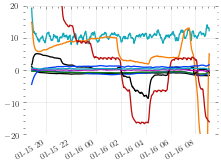

In [12]:
before[0].plot()

plt.ylim(-20,20)

(-20.0, 20.0)

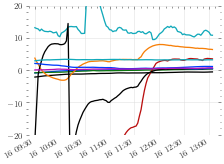

In [17]:
after[0].plot()
plt.ylim(-20,20)

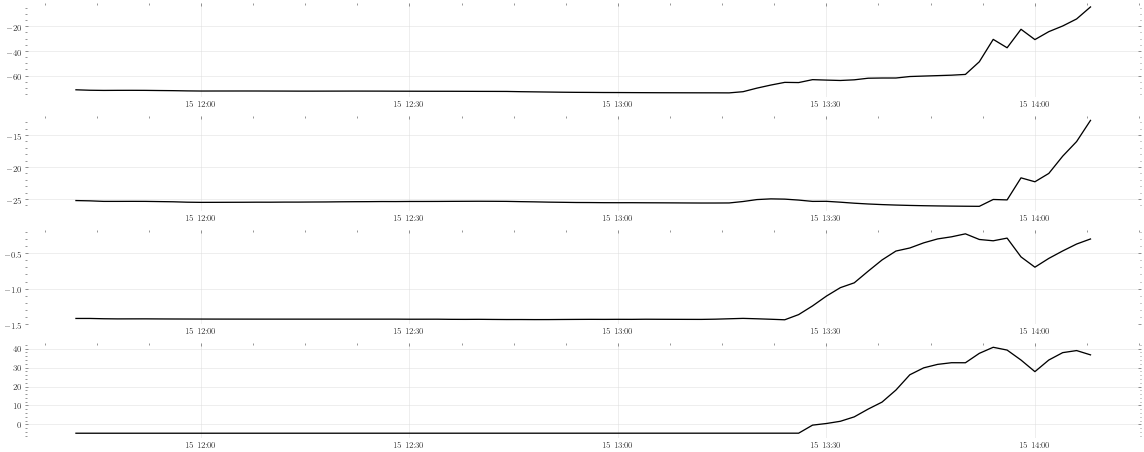

In [18]:
fig, ax = plt.subplots(4,1, figsize=(20,8))

for i, target in enumerate(TARGETS):
    ax[i].plot(df[df.index < times[0]['start']][target])

In [19]:
len(df[df.index < times[0]['start']])

74

In [20]:
times[0]

{'start': datetime.datetime(2020, 1, 15, 14, 10),
 'end': datetime.datetime(2020, 1, 15, 18, 30)}

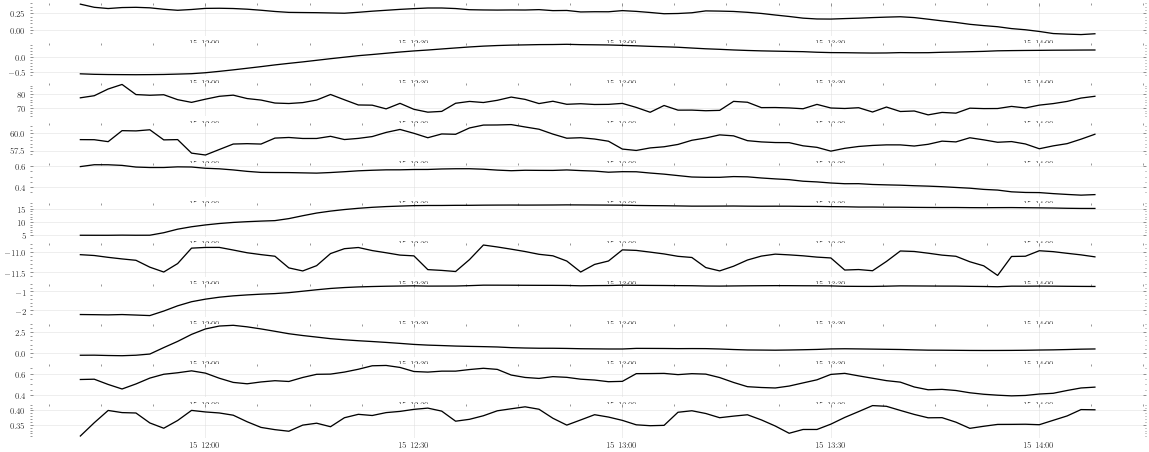

In [21]:
fig, ax = plt.subplots(len(MEAS_COLUMNS), 1, figsize=(20,8))

for i, col in enumerate(MEAS_COLUMNS):
    ax[i].plot(df[df.index < times[0]['start']][col])

In [57]:
df[df.index < times[0]['start']].to_pickle('day_0_baseline')

In [13]:
good_rows = []

for i, row in df[df.index < times[0]['start']].iterrows():
    good_rows.append(row)

for i, row in df[df.index < times[0]['start']][::-1].iterrows():
    good_rows.append(row)
    
for i, row in df[df.index < times[0]['start']].iterrows():
    good_rows.append(row)

In [14]:
df_downsampled = pd.DataFrame(good_rows)

In [16]:
import datetime as dt
import numpy as np

In [17]:
df_downsampled.index = dt.datetime(2010,1,1) + pd.TimedeltaIndex(np.arange(len(df_downsampled))*2, unit='min')

In [20]:
df_downsampled.to_pickle('day_0_long_long_baseline')

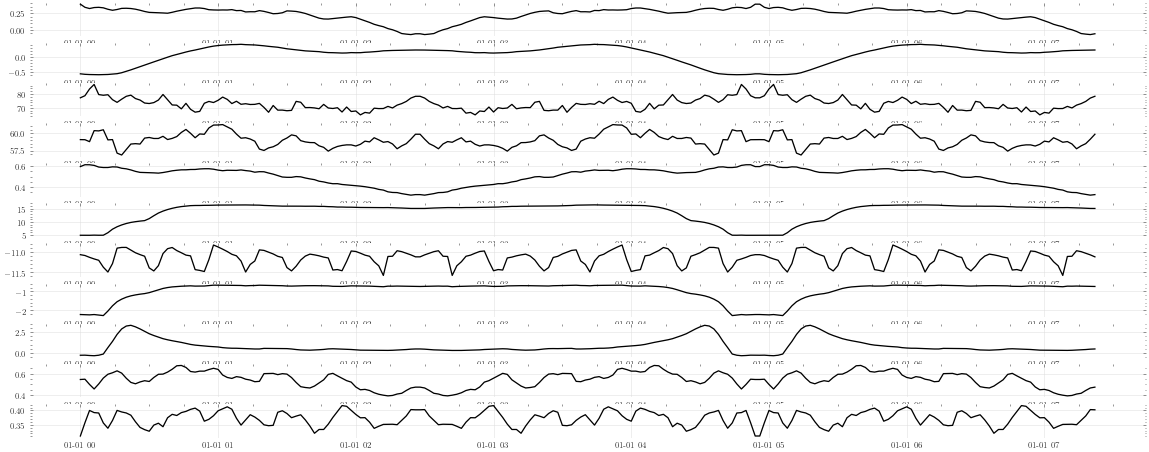

In [22]:
fig, ax = plt.subplots(len(MEAS_COLUMNS), 1, figsize=(20,8))

for i, col in enumerate(MEAS_COLUMNS):
    ax[i].plot(df_downsampled[col])